# Import Dependencies

In [1]:
# System
import os

# Data Analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix

import tensorflow as tf

# Get Data

In [2]:
file_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/cutfree-simulations/runtime_data_v2.csv"
df = pd.read_csv(file_path)
df.iloc[0]

Oligo                        NNNNNN
OligoLength                       6
Sites                   Any["YATR"]
TotalSites                        1
SiteLength                        4
CutFree_Randomer             NBNVVN
CutFree_Degeneracy          7.45472
CutFree_Time               0.006211
CutFreeRL_Randomer           NNVVVN
CutFreeRL_Degeneracy        7.45472
CutFreeRL_Time             0.228063
Name: 0, dtype: object

In [3]:
df.loc[(df["OligoLength"] == 6) & (df["TotalSites"] == 1) & (df["SiteLength"] == 4)]

,Oligo,OligoLength,Sites,TotalSites,SiteLength,CutFree_Randomer,CutFree_Degeneracy,CutFree_Time,CutFreeRL_Randomer,CutFreeRL_Degeneracy,CutFreeRL_Time
0,NNNNNN,6,"Any[""YATR""]",1,4,NBNVVN,7.454720,0.006211,NNVVVN,7.454720,0.228063
1750,NNNNNN,6,"Any[""GATC""]",1,4,HNNNDD,7.454720,0.006383,NNNDDD,7.454720,0.225150
3500,NNNNNN,6,"Any[""GGCC""]",1,4,NHNNDN,7.742402,0.007255,NNNDND,7.742402,0.080954


# Visualize Data

In [4]:
conditions = [
    (df["CutFree_Time"] <= df["CutFreeRL_Time"]),
    (df["CutFree_Time"] > df["CutFreeRL_Time"])
]

values = [0, 1] # 0 = CutFree, 1 = CutFreeRL

df["Algorithm"] = np.select(conditions, values)
df = df[["OligoLength", "TotalSites", "SiteLength", "Algorithm"]]
df

,OligoLength,TotalSites,SiteLength,Algorithm
0,6,1,4,0
1,6,2,4,0
2,6,3,4,0
3,6,4,4,0
4,6,5,4,0
...,...,...,...,...
5244,40,6,8,1
5245,40,7,8,1
5246,40,8,8,1
5247,40,9,8,1


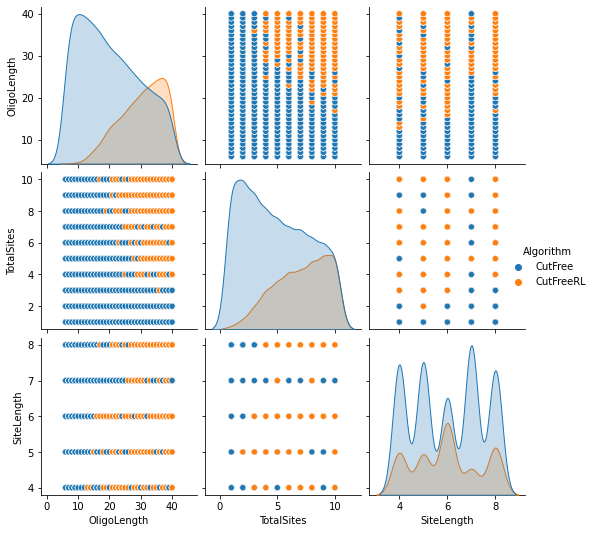

In [5]:
pair_plot = sns.pairplot(df, hue="Algorithm", diag_kind="kde")
new_labels = ["CutFree", "CutFreeRL"]
for t, l in zip(pair_plot._legend.texts, new_labels):
    t.set_text(l)
plt.show(pair_plot)

# Get Train/Test Split

In [6]:
x = df.drop(["Algorithm"], axis=1)
y = df["Algorithm"]

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)
x_train.head()

,OligoLength,TotalSites,SiteLength
2536,21,7,7
3208,35,9,4
3728,10,9,6
2907,29,8,4
1644,38,5,8


In [8]:
y_train.head()

2536    0
3208    1
3728    0
2907    1
1644    1
Name: Algorithm, dtype: int32

In [9]:
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

In [10]:
x_train

<tf.Tensor: shape=(4199, 3), dtype=float32, numpy=
array([[21.,  7.,  7.],
       [35.,  9.,  4.],
       [10.,  9.,  6.],
       ...,
       [13.,  1.,  4.],
       [ 7., 10.,  6.],
       [14.,  8.,  6.]], dtype=float32)>

# Accuracy Function

In [11]:
def get_accuracy(pred, true):
    test_accuracy = accuracy_score(pred, true)*100
    print("Accuracy: {:.2f}%".format(test_accuracy))
    return test_accuracy

# Logistic Regression

In [12]:
logreg = LogisticRegressionCV(cv=10, random_state=0)
logreg.fit(x_train, y_train)

LogisticRegressionCV(cv=10, random_state=0)

In [13]:
y_pred = np.where(logreg.predict(x_test) > 0.5, 1, 0)
get_accuracy(y_pred, y_test)

Accuracy: 80.38%


80.38095238095238

# Support Vector Machine

In [14]:
svc = svm.SVC()
svc.fit(x_train, y_train)

SVC()

In [15]:
y_pred = np.where(svc.predict(x_test) > 0.5, 1, 0)
get_accuracy(y_pred, y_test)

Accuracy: 80.48%


80.47619047619048

# MLP Classifier NN

In [16]:
class_NN = MLPClassifier(max_iter=500, random_state=1)
class_NN.fit(x_train, y_train)

MLPClassifier(max_iter=500, random_state=1)

In [17]:
y_pred = class_NN.predict(x_test)
get_accuracy(y_pred, y_test)

Accuracy: 82.67%


82.66666666666667

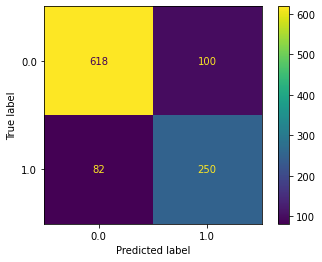

In [18]:
plot_confusion_matrix(class_NN, x_test, y_test)  
plt.show()

In [19]:
print(classification_report(y_pred, y_test, target_names=["CutFree", "CutFreeRL"]))

              precision    recall  f1-score   support

     CutFree       0.86      0.88      0.87       700
   CutFreeRL       0.75      0.71      0.73       350

    accuracy                           0.83      1050
   macro avg       0.81      0.80      0.80      1050
weighted avg       0.82      0.83      0.83      1050

